This uses the open AI gym baseline with some slight modifications. Mostly copied code from here
https://github.com/openai/baselines/tree/master/baselines/ppo1. Looks like the version I got from pip and the version currently on master don't quite sync up. (For example there is no tf_util.save_state fcn so we save manually

In [11]:
from baselines.common.cmd_util import make_mujoco_env, mujoco_arg_parser
from baselines.common import tf_util as U
import tensorflow as tf
from baselines import logger
import os
import sys
from baselines.ppo1 import mlp_policy, pposgd_simple

import gym
import gym_ucsb_robolab
import policies.mlp_relu_policy as mlp_relu_policy

import numpy as np
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib.pyplot as plt
import itertools

#Needed for saving 
import errno, datetime, time, inspect

def train(env_id, num_timesteps, seed=0):

    U.make_session(num_cpu=16).__enter__()
    
    def policy_fn(name, ob_space, ac_space):
        #return mlp_policy.MlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=64, num_hid_layers=64)
        return mlp_relu_policy.ReluMlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=64, num_hid_layers=4)

    env = gym.make(env_id)
    pi = pposgd_simple.learn(env, policy_fn,
            max_timesteps=num_timesteps,
            timesteps_per_actorbatch=2048,
            clip_param=0.2, entcoeff=0.0,
            optim_epochs=10, optim_stepsize=3e-4, optim_batchsize=64,
            gamma=0.99, lam=0.95, schedule='linear',
        )
    env.close()
   
    return pi



def save_results(filename, description = None):
    """ 
    description: saves the results of a run of the second cell (the one that calls train) in this notebook
    
    """

    save_dir = "data/" + filename + "/"
    os.makedirs(save_dir)
    
    if description is None:
        description  = input("please enter a description of the run")
        
    datetime_str = str(datetime.datetime.today())
    datetime_str = datetime_str.replace(" ", "_")
    
    runtime_str = str(datetime.timedelta(seconds = runtime))
    
    readme = open(save_dir + "README.txt", "w+")
    readme.write("datetime: " + datetime_str + "\n\n")
    readme.write("enviroment: " + env_name + "\n\n")
    readme.write("description: " + description + "\n\n")
    readme.write("time_elapsed: " + runtime_str + "\n\n")
    readme.write("num_timesteps: " + str(num_timesteps) + "\n\n")
    readme.write("seed: " + str(seed) + "\n\n")
    readme.close()

    # TODO add code snippets that correspond to the run
    # TODO somehow store the tensorboard logs here after the fact
    
    saver = tf.train.Saver()
    saver.save(tf.get_default_session(), save_dir + filename)
    
    os.rename("./tmp_logs/", save_dir + "tensorboard")
   
   
#env_name = "Acrobot-v1"
env_name = "InvertedPendulum-v2"
#env_name = 'InvertedPendulumPyBulletEnv-v0'
#env_name = "su_cartpole_et-v0"
#env_name = "InvertedDoublePendulum-v2"


In [ ]:
start_time = time.time()


num_timesteps = 2e5
seed = 0

logger.configure(dir = "./tmp_logs", format_strs=["tensorboard"] )
with tf.device("/cpu:0"):    
    pi= train(env_name, num_timesteps=num_timesteps, seed=seed)
    
runtime = time.time() - start_time


In [ ]:
env = make_mujoco_env(env_name,seed=0)
ob = env.reset()     

while True:
    action = pi.act(stochastic=False, ob=ob)[0]
    ob, _, done, _ =  env.step(action)
    #if reward == 1:
    #    print("balanced")
    env.render()
    if done:
        ob = env.reset()
        
#U.save_state("./saved/5mil_flat")

In [4]:
#def loaded_policy_fn(name, ob_space, ac_space):
#    return mlp_policy.MlpPolicy(name=name, ob_space=ob_space, ac_space=ac_space, hid_size=64, num_hid_layers=2)

#loader = tf.train.Saver()
#session = loader.restore(tf.get_default_session(), 'saved/test.save')

#env_name = "Acrobot1"

save_name = 'invertedpendulum_3layer'

logger.configure()

pi = train(env_name, num_timesteps=1, seed=0)
U.load_state(os.getcwd() + '/data/'+ save_name + '/' + save_name)
#os.makedirs(os.path.dirname("./saved"), exist_ok=True)
#saver = tf.train.Saver()
#saver.save(tf.get_default_session(), "./saved/test.save")
    
#env = make_mujoco_env('Walker2d-v2',seed=0)
# env = gym.make(env_name)
# ob = env.reset()     

# while True:
#     action = pi.act(stochastic=False, ob=ob)[0]
#     ob, _, done, _ =  env.step(action)
#     env.render()
#     if done:
#         ob = env.reset()

Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2018-12-03-18-14-20-645176
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
********** Iteration 0 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00404 |       0.00000 |      31.91203 |       0.00106 |       1.41588
     -0.01425 |       0.00000 |      28.82775 |       0.00554 |       1.40938
     -0.02320 |       0.00000 |      21.68383 |       0.00886 |       1.40446
     -0.02608 |       0.00000 |      12.14870 |       0.01451 |       1.40031
     -0.02813 |       0.00000 |       8.85815 |       0.01376 |       1.39585
     -0.02966 |       0.00000 |       8.02341 |       0.01668 |       1.39227
     -0.03138 |       0.00000 |       7.58140 |       0.01510 |       1.38839
     -0.03294 |       0.00000 |   

In [ ]:
pi.get_variables()

In [ ]:
mlp_policy.MlpPolicy

In [ ]:
all_weights = pi.get_variables()
fc1 = all_weights[4]

In [ ]:
fc1_weights = fc1.value()

In [ ]:
fc1_weights.eval() > 0


In [5]:
#input_data = np.mgrid[-10:10, -10:10, -10:10, -10:10]
#output_data = np.zeros(input_data.shape[1:])


#[ac, pred] = pi.act(0, np.array([-10 ,-10, 1, 1]))

# This is bad and I don't care

# for i in range(len(input_data[0,:,0,0,0])):
#     for j in range(len(input_data[0,0,:,0,0])):
#         for k in range(len(input_data[0,0,0,:,0])):
#             for n in range(len(input_data[0,0,0,0,:])):
#                 output_data[i,j,k,n], _  = pi.act(0, input_data[:,i,j,k,n])
                
                
input_iter = itertools.combinations_with_replacement(range(-10,11),4)
input_data = np.array([np.array(x) for x in input_iter],dtype='float32')
output_data = np.array([pi.act(0, x)[0] for x in input_data],dtype='float32')
# We'll probably have to sample from this later...

In [6]:
input_iter = itertools.combinations_with_replacement(range(-10,11),2)
input_data = np.array([np.concatenate((np.zeros(2), np.array(x))) for x in input_iter],dtype='float32')
output_data = np.array([pi.act(0, x)[0] for x in input_data],dtype='float32')

In [7]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()

regr.fit(input_data,output_data.T.flatten())
#regr.fit(input_data,output_data)
#regr.fit(index, output_data.T.flatten())

lin_predict = regr.predict(input_data)
#lin_predict = regr.predict(index)

print("coefs are", regr.coef_)
print("mean sqared error:", mean_squared_error(lin_predict, output_data))

coefs are [  0.        -12.5108      2.6607728   6.11889  ]
mean sqared error: 1162.681


<IPython.core.display.Javascript object>


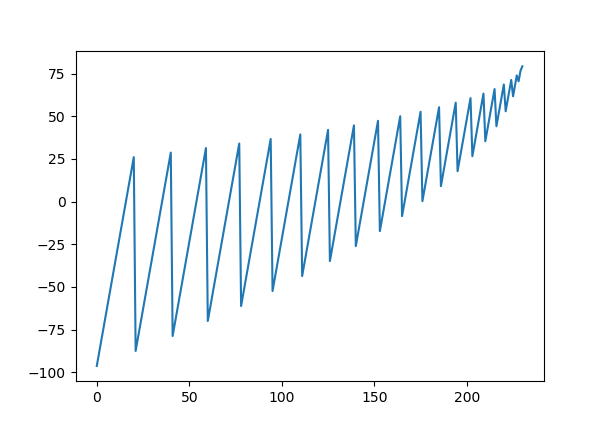

In [8]:
plt.plot(output_data)
plt.figure()
plt.plot(lin_predict)

In [ ]:
input_data = np.array([[x, 0, 0, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,0], output_data)
plt.figure()

input_data = np.array([[0, x, 0, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,1], output_data)
plt.figure()

input_data = np.array([[0, 0, x, 0] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,2], output_data)
plt.figure()

input_data = np.array([[0, 0, 0, x] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,3], output_data)
plt.figure()

input_data = np.array([[x, x, x, x] for x in range(-10,11)])
output_data = np.array([pi.act(0, x)[0] for x in input_data])
plt.plot(input_data[:,0], output_data)

In [ ]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
theta = 2 * np.pi * np.random.random(1000)
r = 6 * np.random.random(1000)
x = np.ravel(r * np.sin(theta))
y = np.ravel(r * np.cos(theta))
z = f(x, y)

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, cmap='viridis', linewidth=0.5);

In [13]:
x = input_data[:,2]
y = input_data[:,3]
z= output_data.flatten()
z2 = lin_predict.flatten()

<IPython.core.display.Javascript object>


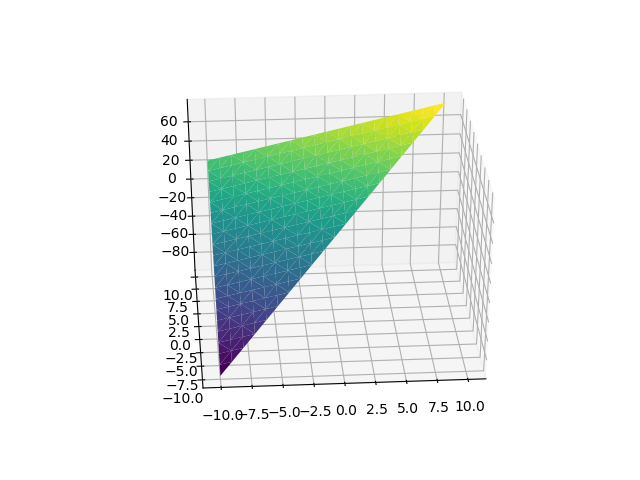

In [15]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');

ax2 = plt.axes(projection='3d')
ax2.plot_trisurf(x, y, z2, cmap='viridis', edgecolor='none');





In [ ]:
plt.plot(x,y)
plt.show();

<IPython.core.display.Javascript object>


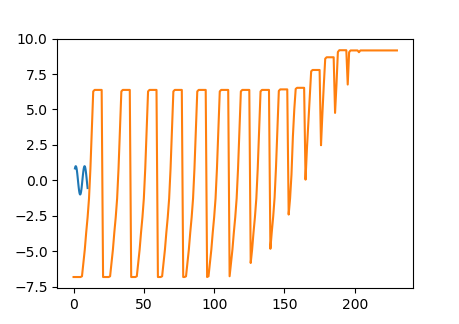

In [3]:
x = np.linspace(1,10)
plt.plot(x,np.sin(x))